In [1]:
import torch
from torch import nn # nn contains all of pytorch's building blocks to a neural network
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch.utils.data as dataUtil

/home/operation/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Name                      0.062777
lrSetPointTension         0.952167
lrDeadTimeCompensation         NaN
aMeasuredTension[1]       0.999890
aMeasuredTension[2]       0.999587
lrPIDVelocity            -0.035573
lrSyncVelocity            0.009344
lrTotalTorqueAdditive     0.529664
lrAccelerationRead       -0.058066
lrVelocityRead            0.003743
lrActDiameter            -0.014610
lrMeasuredForce           1.000000
Name: lrMeasuredForce, dtype: float64


<AxesSubplot:>

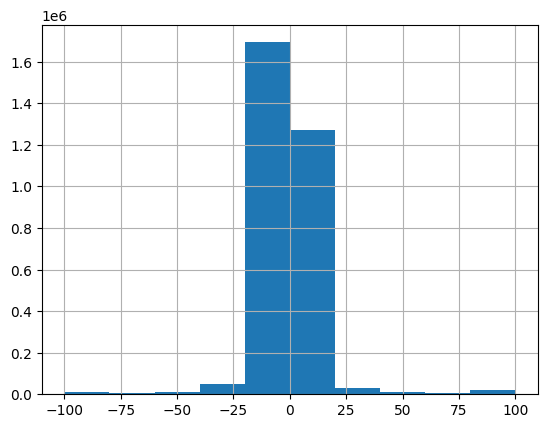

In [2]:
data = pd.concat([
                # pd.read_csv("./VariablesToSave.1.csv",sep=";"),
                # pd.read_csv("./VariablesToSave.2.csv",sep=";"),
                # pd.read_csv("./VariablesToSave.3.csv",sep=";"),
                pd.read_csv("./VariablesToSave.4.csv",sep=";")
                ])
corr_matrix = data.corr()
print(corr_matrix["lrMeasuredForce"])
data['lrPIDVelocity'].hist()

In [3]:
data = data.drop("Name",axis="columns")
data = data.drop("lrSetPointTension",axis="columns")
data = data.drop("lrDeadTimeCompensation",axis="columns")
data = data.drop("lrTotalTorqueAdditive",axis="columns")
data = data.drop("lrAccelerationRead",axis="columns")
data = data.drop("lrVelocityRead",axis="columns")
data = data.drop("lrActDiameter",axis="columns")
data = data.drop("lrSyncVelocity",axis="columns")
# data = data.drop("aMeasuredTension[1]",axis="columns")
# data = data.drop("aMeasuredTension[2]",axis="columns")

# data.to_csv("./data.csv",encoding='utf-8', index=False,sep=";")

In [4]:
# class MachineStatePredictor(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(MachineStatePredictor, self).__init__()
#         self.hidden_size = hidden_size
#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
#         self.fc1 = nn.Linear(hidden_size, 128)
#         self.fc2 = nn.Linear(128, output_size)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         _, (hidden, _) = self.lstm(x)
#         x = self.fc1(hidden[-1])  # Taking the last hidden state
#         x = self.relu(x)
#         x = self.fc2(x)
#         return x

In [5]:
y=torch.tensor(data["lrMeasuredForce"],dtype=torch.float32).unsqueeze(dim=1)
data = data.drop("lrMeasuredForce",axis="columns")
X=torch.tensor(list(data.values),dtype=torch.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X[0:10])

tensor([[42.7680, 42.7680, -0.2985],
        [42.8706, 42.7680, -0.4056],
        [42.8166, 42.8706, -0.3468],
        [42.9192, 42.8166, -0.4540],
        [42.8706, 42.9192, -0.4009],
        [42.9192, 42.8706, -0.4510],
        [42.9192, 42.9192, -0.4496],
        [42.9678, 42.9192, -0.4998],
        [42.9678, 42.9678, -0.4986],
        [42.9678, 42.9678, -0.4974]])


/tmp/ipykernel_2561832/2929382495.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  X=torch.tensor(list(data.values),dtype=torch.float32)


In [6]:
# model = MachineStatePredictor(len(X[0]), 64, 1)
model = nn.Sequential(nn.Linear(len(X[0]),64),nn.ReLU()
                      ,nn.Linear(64,32),nn.ReLU()
                      ,nn.Linear(32,1))

Epoch 0: train RMSE 50.0649, test RMSE 50.0750
Epoch 10: train RMSE 40.2061, test RMSE 40.2143
Epoch 20: train RMSE 29.7453, test RMSE 29.7513
Epoch 30: train RMSE 17.4829, test RMSE 17.4846
Epoch 40: train RMSE 5.2816, test RMSE 5.2741
Epoch 50: train RMSE 3.5717, test RMSE 3.5655
Epoch 60: train RMSE 1.6677, test RMSE 1.6672
Epoch 70: train RMSE 1.4201, test RMSE 1.4209
Epoch 80: train RMSE 0.6442, test RMSE 0.6443
Epoch 90: train RMSE 0.7765, test RMSE 0.7760


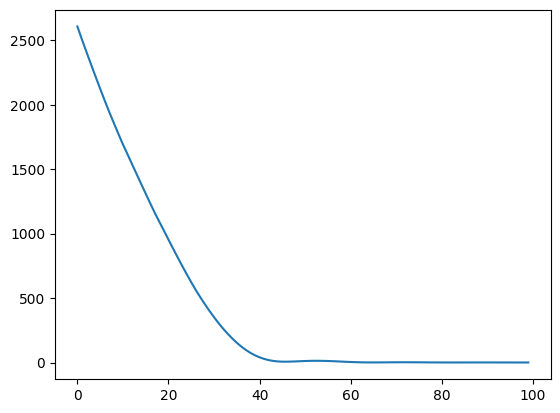

/home/operation/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


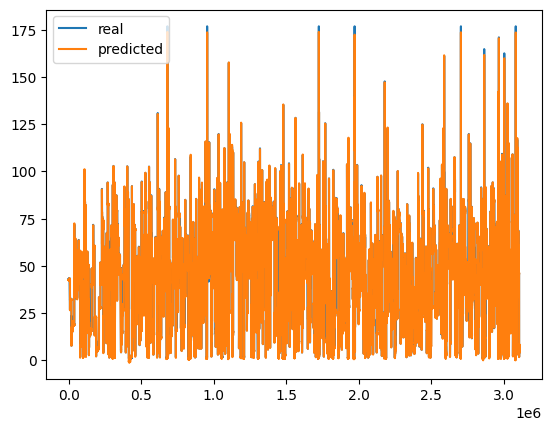

In [7]:
loss_fn=nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs=100
loss_history=[]
test_loss_history=[]
loader = dataUtil.DataLoader(dataUtil.TensorDataset(X_train, y_train)
                             , shuffle=True, batch_size=int(len(X_train/2)))
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss_history.append(loss.to('cpu').detach().numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f"
           % (epoch, train_rmse, test_rmse))
plt.plot(loss_history)
plt.show()
with torch.inference_mode():
    y_predicted=model(X)
    plt.plot(y.to("cpu"),label="real")
    plt.plot(y_predicted.to("cpu"),label="predicted")
    plt.legend()
    plt.show()


In [8]:
torch.save(model.state_dict(), "../model_3-64-32-1")

In [11]:
import timeit
start = timeit.timeit()
model(X[0])
end = timeit.timeit()
print(end - start)

0.000238027423620224


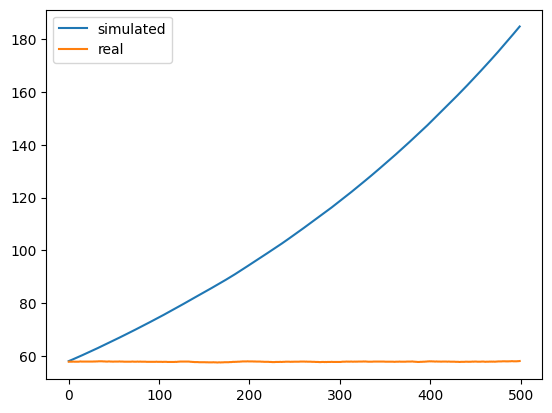

In [11]:
# tension_1 tension_2 Pid velocity
start=54500
end=55000
history=[]
tension_1 =X[start][0]
tension_2 =X[start][1]
# torque =X[start:end][:,3]
controllerOutput = X[start:end][:,2]
tension_real =  y[start:end]
# # speed = X[start:end][:,3]
for i in range(len(controllerOutput)):
    #create real tensor 
    # input = torch.tensor([tension_1,tension_2,controllerOutput[i],speed[i]],dtype=torch.float32)
    input = torch.tensor([tension_1,tension_2,controllerOutput[i]],dtype=torch.float32)
    tension_0 = model(input).to('cpu').detach().numpy()[0]
    history.append(tension_0)
    tension_2=tension_1
    tension_1=tension_0
plt.plot(history,label="simulated")
plt.plot(tension_real,label="real")
# plt.plot(controllerOutput,label="outputs")
plt.legend()
plt.show()